In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [9]:
# 1) Load datasets directly from the portal
ped_url = "https://data.melbourne.vic.gov.au/api/v2/catalog/datasets/pedestrian-counting-system-monthly-counts-per-hour/exports/csv?delimiter=%2C"
biz_url = "https://data.melbourne.vic.gov.au/api/v2/catalog/datasets/business-establishments-and-jobs-data-by-business-size-and-industry/exports/csv?delimiter=%2C"

ped = pd.read_csv(ped_url, low_memory=False)
biz = pd.read_csv(biz_url, low_memory=False)

print("Ped shape:", ped.shape, "| Biz shape:", biz.shape)


Ped shape: (1387730, 9) | Biz shape: (15414, 7)


In [10]:

date_col = next((c for c in ped.columns if "date" in c.lower()), None)
count_col = next((c for c in ped.columns if "count" in c.lower()), None)
if date_col is None or count_col is None:
    raise ValueError("Could not find date/count columns in pedestrian dataset. Check column names.")

ped[date_col] = pd.to_datetime(ped[date_col], errors="coerce")
ped["year"] = ped[date_col].dt.year
ped_annual = (ped.groupby("year", as_index=False)[count_col]
                .sum()
                .rename(columns={count_col: "total_pedestrians"}))

In [11]:
# 3) Clean + aggregate business -> annual for SMALL businesses (1–19 jobs)
biz.columns = [c.strip().lower().replace(" ", "_") for c in biz.columns]


required = ["census_year","business_size","total_establishments","total_jobs"]
for r in required:
    if r not in biz.columns:
        raise ValueError(f"Missing '{r}' in business dataset. Found columns: {sorted(biz.columns)}")

# Build a "small" mask (covers '1 to 19' or 'Small' labels)
size_col = biz["business_size"].astype(str)
is_small = size_col.str.contains("small", case=False, na=False) | (
    size_col.str.contains("1", na=False) & size_col.str.contains("19", na=False)
)
biz_small = biz[is_small].copy()

biz_year = (biz_small.groupby("census_year", as_index=False)
            .agg(total_small_establishments=("total_establishments", "sum"),
                 total_small_jobs=("total_jobs", "sum"))
            .rename(columns={"census_year": "year"}))


In [5]:

# 4) Merge on year (inner keeps overlapping years only)
df = ped_annual.merge(biz_year, on="year", how="inner").sort_values("year").reset_index(drop=True)

,year,total_pedestrians,total_small_establishments,total_small_jobs
0,2023,104281795,30246,190634.0


In [12]:
# 5) % change (2019 -> 2023) table
pre_year, post_year = 2019, 2023

def pct_change(series, y0, y1):
    a = series.loc[df["year"].eq(y0)]
    b = series.loc[df["year"].eq(y1)]
    if a.empty or b.empty or a.values[0] == 0:
        return np.nan
    return (b.values[0] - a.values[0]) / abs(a.values[0]) * 100

summary = pd.Series({
    "Pedestrians %Δ (2019→2023)": pct_change(df["total_pedestrians"], pre_year, post_year),
    "Small establishments %Δ (2019→2023)": pct_change(df["total_small_establishments"], pre_year, post_year),
    "Small jobs %Δ (2019→2023)": pct_change(df["total_small_jobs"], pre_year, post_year),
}).round(2)

print("\nMerged (first/last rows):")
display(df.head(3))
display(df.tail(3))

print("\n=== Mid-trimester summary ===")
display(summary.to_frame("Percent change"))


Merged (first/last rows):


,year,total_pedestrians,total_small_establishments,total_small_jobs
0,2023,104281795,30246,190634.0


,year,total_pedestrians,total_small_establishments,total_small_jobs
0,2023,104281795,30246,190634.0



=== Mid-trimester summary ===


,Percent change
Pedestrians %Δ (2019→2023),NaN
Small establishments %Δ (2019→2023),NaN
Small jobs %Δ (2019→2023),NaN


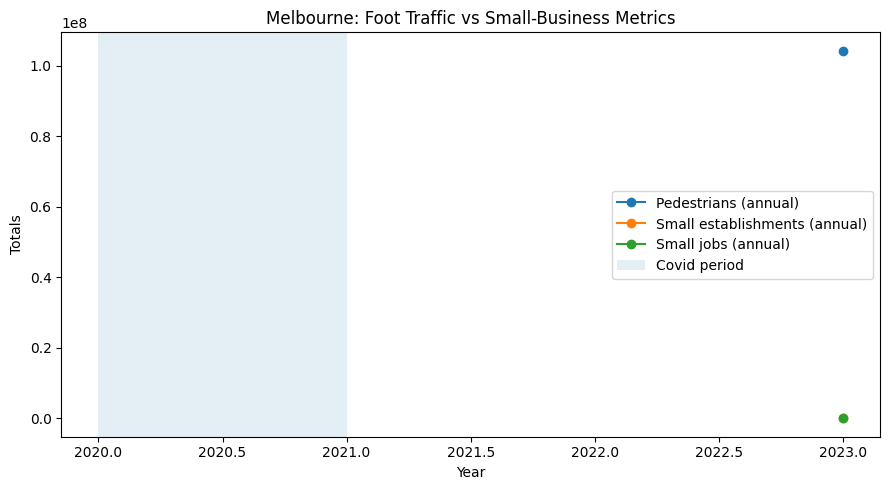

In [13]:
# 6) Visuals
# Line chart — trends
plt.figure(figsize=(9,5))
plt.plot(df["year"], df["total_pedestrians"], marker='o', label="Pedestrians (annual)")
plt.plot(df["year"], df["total_small_establishments"], marker='o', label="Small establishments (annual)")
plt.plot(df["year"], df["total_small_jobs"], marker='o', label="Small jobs (annual)")
plt.axvspan(2020, 2021, alpha=0.12, label="Covid period")
plt.title("Melbourne: Foot Traffic vs Small-Business Metrics")
plt.xlabel("Year")
plt.ylabel("Totals")
plt.legend()
plt.tight_layout()
plt.show()
